In [502]:
import numpy as np
from IPython.display import clear_output
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
from scipy.linalg import pinv, det
import time
np.random.seed(71)

### Data Generation

In [736]:
def create_data_normal(n_groups=3, num_fts=2, std=0.5, scale=10, sizes=1000):
    """Always return normalized data
        - In General always normalize the data before processing"""
    data_x = []
    data_y = []
    for group in np.arange(n_groups):
        emb_fts = []
        for fts in np.arange(num_fts):
            mean = np.random.uniform(0, scale, size=1)[0]
            emb_fts.append(np.random.normal(mean, std[group], size=(sizes[group], 1)))
        data_x.append(np.hstack(emb_fts))
        data_y.append([group]*sizes[group])
    X = np.vstack(data_x)
#     _mean = np.mean(X, axis=0).reshape(1, -1)
#     _std = np.std(X, axis=0).reshape(1, -1)
#     X = (X-_mean)/_std
    return X, np.concatenate(data_y)

### Utils

In [737]:
def plot_data(X, mu=None, doc_prob=None, color="k", marker=".", legend=f"centers"):
    clear_output(wait=True)
    plt.cla()
    if doc_prob is None:
        plt.scatter(X[:, 0], X[:, 1], color=color, marker=marker)
    else:
        cluster_idx = np.argmax(doc_prob, axis=1)
        _uni_clusters = np.unique(cluster_idx)
        for idx, _cidx in enumerate(_uni_clusters):
            _X = X[cluster_idx==_cidx]
            plt.scatter(_X[:, 0], _X[:, 1], color=colors[idx], marker=marker)
            
    if mu is not None:
        plt.scatter(mu[:, 0], mu[:, 1], color="r", marker="^", label=legend)
    plt.xlabel(r"$\mathbf{X}_0$", fontsize=16)
    plt.ylabel(r"$\mathbf{X}_1$", fontsize=16)
    plt.legend()
    plt.show()
    
def plot_lld(likelyhood):
    clear_output(wait=True)
    plt.cla()
    x = np.arange(len(likelyhood))
    plt.plot(x, likelyhood)
    plt.xlabel(r"iteration", fontsize=16)
    plt.ylabel(r"LL(D)", fontsize=16)
    plt.xticks(x, x+1)
    plt.show()

def plot_decision_boundary_kmeans(X, mu, phi, h=0.02):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    _min, _max = min(x_min, y_min), max(x_max, y_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
    Z = np.argmax(compute_score_kmeans(x, mu, phi), axis=1).reshape(xx.shape)
    plt.scatter(X[:, 0], X[:, 1], color="k", marker=".")
    if mu is not None:
        plt.scatter(mu[:, 0], mu[:, 1], color="r", marker="^")
    plt.xlabel(r"$\mathbf{X}_0$", fontsize=16)
    plt.ylabel(r"$\mathbf{X}_1$", fontsize=16)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=.5)
    plt.show()

    
def plot_decision_boundary_gda(X, mu, sigma, phi, n_clusters, h=0.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    _min, _max = min(x_min, y_min), max(x_max, y_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
    same_sigma = len(sigma.shape) == 2
    
    Z = np.argmax(compute_score_gda(x, mu, sigma, phi, n_clusters, same_sigma), axis=1).reshape(xx.shape)
    plt.scatter(X[:, 0], X[:, 1], color="k", marker=".")
    if mu is not None:
        plt.scatter(mu[:, 0], mu[:, 1], color="r", marker="^")
    plt.xlabel(r"$\mathbf{X}_0$", fontsize=16)
    plt.ylabel(r"$\mathbf{X}_1$", fontsize=16)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=.5)
    plt.show()

No handles with labels found to put in legend.


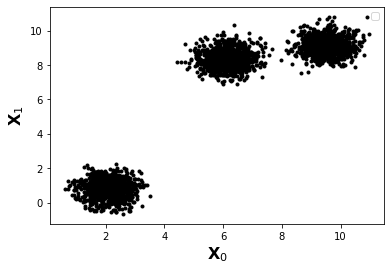

In [745]:
n_cluster=3
num_fts = 2
std = [0.5 for x in range(n_cluster)]
sizes = [1000 for x in range(n_cluster)]
colors = np.random.random((n_cluster, 3))
X, y= create_data_normal(n_cluster, num_fts, std=std, sizes=sizes)
plot_data(X)

### K-Means starts here

In [746]:
def compute_score_kmeans(X, mu, phi):
    _dscore = np.exp(-0.5*np.power(euclidean_distances(mu, X),2))*phi.reshape(-1, 1)
    return _dscore.T

def compute_params_kmeans(X, assignment, n_clusters):
        c_idx = np.argmax(assignment, axis=1)
        mus, phis = np.zeros((n_clusters, X.shape[1])), np.full(n_clusters, 1e-3)
        for idx in range(n_clusters):
            didx = np.where(c_idx==idx)[0]
            if didx.size > 0:
                _x = X[didx]
                _mu = np.mean(_x, axis=0)
                mus[idx, :] = _mu
                phis[idx] = didx.size / X.shape[0]
        return mus, phis

In [747]:
def do_kmeans(X, n_iter, kmeanspp=False):
    if kmeanspp:
        mu = X[np.random.choice(X.shape[0], size=n_cluster)]
        phi = np.ones(n_cluster)/n_cluster
    else:
        mu = np.random.uniform(size=(n_cluster, num_fts))
        phi = np.ones(n_cluster)/n_cluster
    
    likelyhood = []

    for it in np.arange(n_iter):
        doc_prob = compute_score_kmeans(X, mu, phi)
        lld = np.mean(np.log(np.max(doc_prob, axis=1)))
        mu, phi = compute_params_kmeans(X, doc_prob, n_cluster)
        plot_data(X, mu, doc_prob, legend=f"it={it+1}")
        time.sleep(0.2)
        likelyhood.append(lld)
    return mu, phi, likelyhood

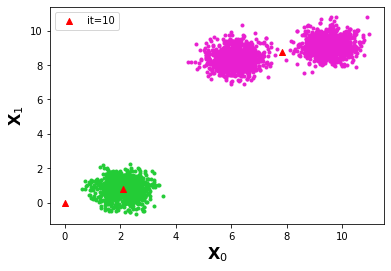

In [753]:
mu, phi, likelyhood = do_kmeans(X, 10, False)

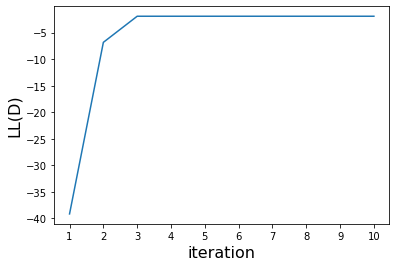

In [754]:
plot_lld(likelyhood)

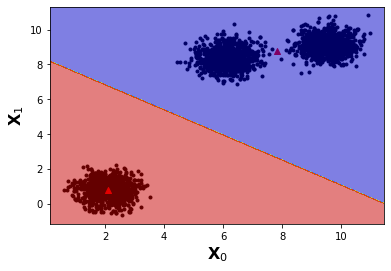

In [755]:
plot_decision_boundary_kmeans(X, mu, phi)

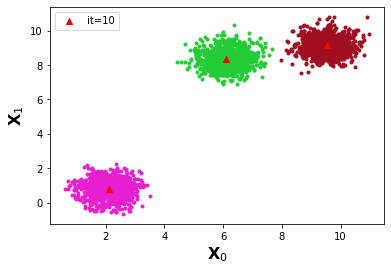

In [756]:
mu, phi, likelyhood = do_kmeans(X, 10, True)

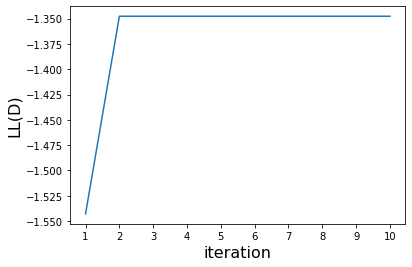

In [757]:
plot_lld(likelyhood)

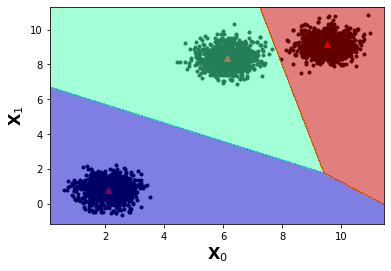

In [758]:
plot_decision_boundary_kmeans(X, mu, phi)

No handles with labels found to put in legend.


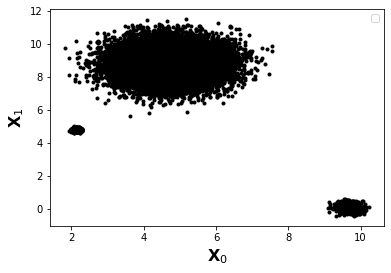

In [759]:
std = [np.random.random() for x in range(n_cluster)]
sizes = [1000 for x in range(n_cluster)]
sizes[np.argmax(std)] = 20000
colors = np.random.random((n_cluster, 3))
X, y= create_data_normal(n_cluster, num_fts, std=std, sizes=sizes)
plot_data(X)

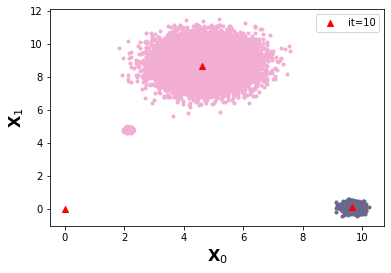

In [760]:
mu, phi, _ = do_kmeans(X, 10, True)

### GDA - Starts here

In [761]:
def compute_score_gda(X, mu, sigma, phi, n_clusters, same_sigma=False):
    scores = []
    for cluster in range(n_clusters):
        _mu = mu[cluster]
        _X = X - _mu
        if same_sigma:
            _sigma = sigma
        else:
            _sigma = sigma[cluster]
        det_sigma = np.sqrt(det(_sigma))
        inv_sigma = pinv(_sigma)
        logit = -0.5*np.sum(_X.dot(inv_sigma)*_X, axis=1)
        scores.append(np.exp(logit)*phi[cluster]/(det_sigma* np.power(2*np.pi, num_fts/2)))
    score = np.vstack(scores).T
    return score

def compute_params_gda(X, assignment, n_clusters, same_sigma=False):
    c_idx = np.argmax(assignment, axis=1)
    mus, sigmas, _xs, phis = [], [], [], np.zeros(n_clusters)
    for idx in range(n_clusters):
        didx = np.where(c_idx==idx)[0]
        _x = X[didx]
        _mu = np.mean(_x, axis=0)
        mus.append(_mu)
        if same_sigma:
            _xs.append(_x.T - _mu.reshape(-1, 1))
        else:
            sigmas.append(np.cov(_x.T - _mu.reshape(-1, 1)))
        phis[idx] = didx.size / X.shape[0]
    if same_sigma:
        _xs = np.hstack(_xs)
        sigmas = np.cov(_xs)
    return np.stack(mus, axis=0), np.stack(sigmas, axis=0), phis

In [762]:
def do_GDA(X, n_iter, same_sigma=False):
    mu = X[np.random.choice(X.shape[0], size=n_cluster)]
    phi = np.ones(n_cluster)/n_cluster
    if same_sigma:
        sigma = np.eye(num_fts)
    else:
        sigma = np.stack(np.eye(num_fts) for _ in range(n_cluster))
    likelyhood = []
    for it in np.arange(n_iter):
        doc_prob = compute_score_gda(X, mu, sigma, phi, n_cluster, same_sigma=same_sigma)
        lld = np.mean(np.log(np.max(doc_prob, axis=1)))
        mu, sigma, phi = compute_params_gda(X, doc_prob, n_cluster, same_sigma=same_sigma)
        plot_data(X, mu, doc_prob, legend=f"iter={it+1}")
        likelyhood.append(lld)
        time.sleep(0.2)
    return mu, sigma, phi, likelyhood

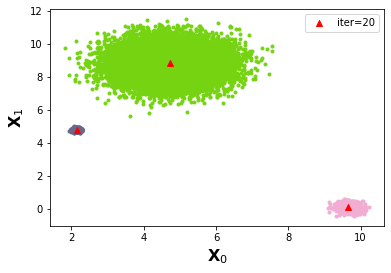

In [765]:
mu, sigma, phi, likelyhood = do_GDA(X, 20, False)

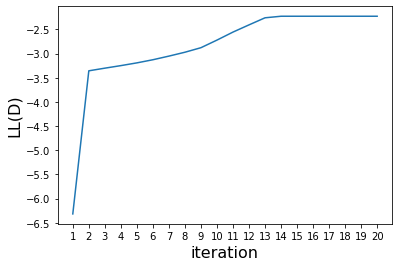

In [766]:
plot_lld(likelyhood)

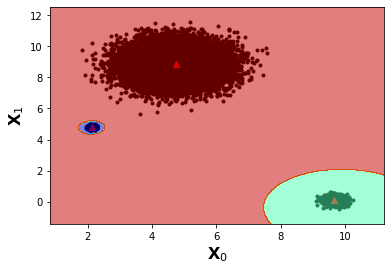

In [767]:
plot_decision_boundary_gda(X, mu, sigma, phi, n_cluster)

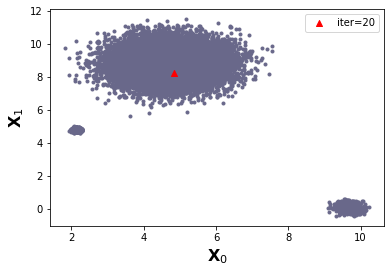

In [769]:
mu, sigma, phi, _ = do_GDA(X, 20, True)

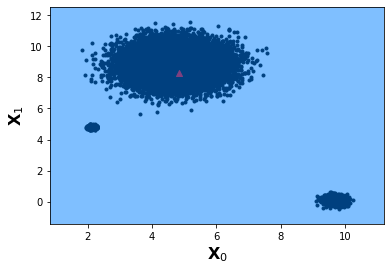

In [770]:
plot_decision_boundary_gda(X, mu, sigma, phi, n_cluster)